In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
plt.style.use('default')
from pyfermions import *

# Energy density

In [2]:
%%time
RECOMPUTE = False
FILENAME = 'mera2d_energies.csv'

if RECOMPUTE:
    # XXX: determine more systematically
    M_x = M_y = 10
    print('M_x = %d, M_y = %d' % (M_x, M_y))

    data = {'K': [], 'L': [], 'M_x': [], 'M_y': [], 'E': []}
    for K in range(1, 5 + 1):
        for L in range(1, 10 + 1):
            if K + L > 7:
                continue
            print('K = %s, L = %s' % (K, L))

            E = mera2d.selesnick(K, L).energy(M_x, M_y)
            data['M_x'].append(M_x)
            data['M_y'].append(M_y)
            data['K'].append(K)
            data['L'].append(L)
            data['E'].append(E)

    energies = pd.DataFrame(data)

    print('Saving to %s...' % FILENAME)
    energies.to_csv(FILENAME)
else:
    print('Loading %s...' % FILENAME)
    energies = pd.read_csv(FILENAME)
    M_x = energies['M_x'].unique()
    M_y = energies['M_y'].unique()
    assert len(M_x) == len(
        M_y) == 1, 'Expecting a single precision only at this point.'
    M_x, M_y = M_x[0], M_y[0]
    print('Done (M_x = %s, M_y = %s)' % (M_x, M_y))

Loading mera2d_energies.csv...
Done (M_x = 10, M_y = 10)
CPU times: user 4.51 ms, sys: 1.76 ms, total: 6.27 ms
Wall time: 8.36 ms


Collect bond dimension and relative errors:

In [3]:
energies['chi'] = (2**(energies['K'] + energies['L']))**2

E_expected = -8 / np.pi**2
energies['rel_error'] = (E_expected - energies['E']) / E_expected

energies

,Unnamed: 0,E,K,L,M_x,M_y,chi,rel_error
0,0,-0.788821,1,1,10,10,16,0.026831
1,1,-0.807136,1,2,10,10,64,0.004235
2,2,-0.809844,1,3,10,10,256,0.000895
3,3,-0.810391,1,4,10,10,1024,0.000220
4,4,-0.810520,1,5,10,10,4096,0.000061
5,5,-0.810554,1,6,10,10,16384,0.000020
6,6,-0.797631,2,1,10,10,64,0.015962
7,7,-0.809304,2,2,10,10,256,0.001562
8,8,-0.810380,2,3,10,10,1024,0.000233
9,9,-0.810533,2,4,10,10,4096,0.000045


# Plot for our paper

In [4]:
# bond dimension vs. minimal relative error
min_errors = energies.groupby('chi').rel_error.agg(
    ['min']).rename(columns={
        'min': 'min_rel_error'
    }).reset_index()
min_errors

,chi,min_rel_error
0,16,0.026831
1,64,0.004235
2,256,0.000895
3,1024,0.000220
4,4096,0.000045
5,16384,0.000011


In [5]:
# exponential fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.log2(min_errors['chi']), np.log2(min_errors['min_rel_error']))

slope, intercept

(-1.1095261445003968, -1.0529143680128232)

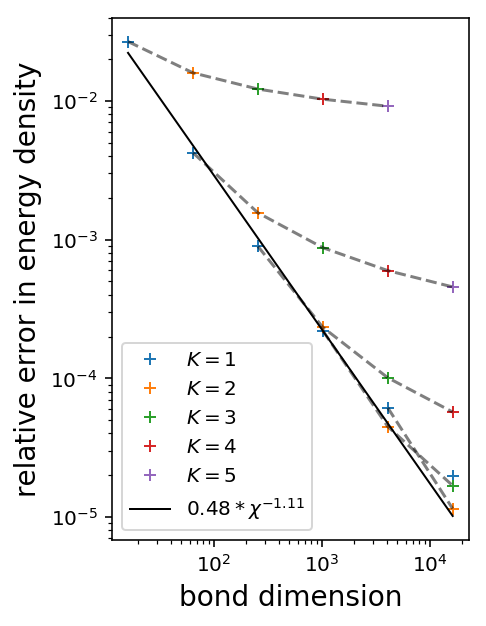

In [6]:
plt.figure(figsize=(3.2, 4.8))
chi = energies['chi'].unique()

# our results
for K, data in energies.groupby(['K']):
    plt.loglog(data['chi'], data['rel_error'], '+', label='$K = %d$' % K)

for L, data in energies.groupby(['L']):
    plt.loglog(
        data['chi'],
        data['rel_error'],
        '--',
        color='black',
        alpha=.5,
        label='_nolegend_')

# exponential fit
plt.loglog(
    chi,
    2**intercept * chi**slope,
    '-b',
    color='black',
    linewidth=1,
    label='$%.02f * \chi^{-%.2f}$' % (2**intercept, -slope))

plt.legend()
plt.xlabel('bond dimension', fontsize=14)
plt.ylabel('relative error in energy density', fontsize=14)
# plt.show()

plt.savefig('energies2d.pdf', bbox_inches='tight')

# Phase structure

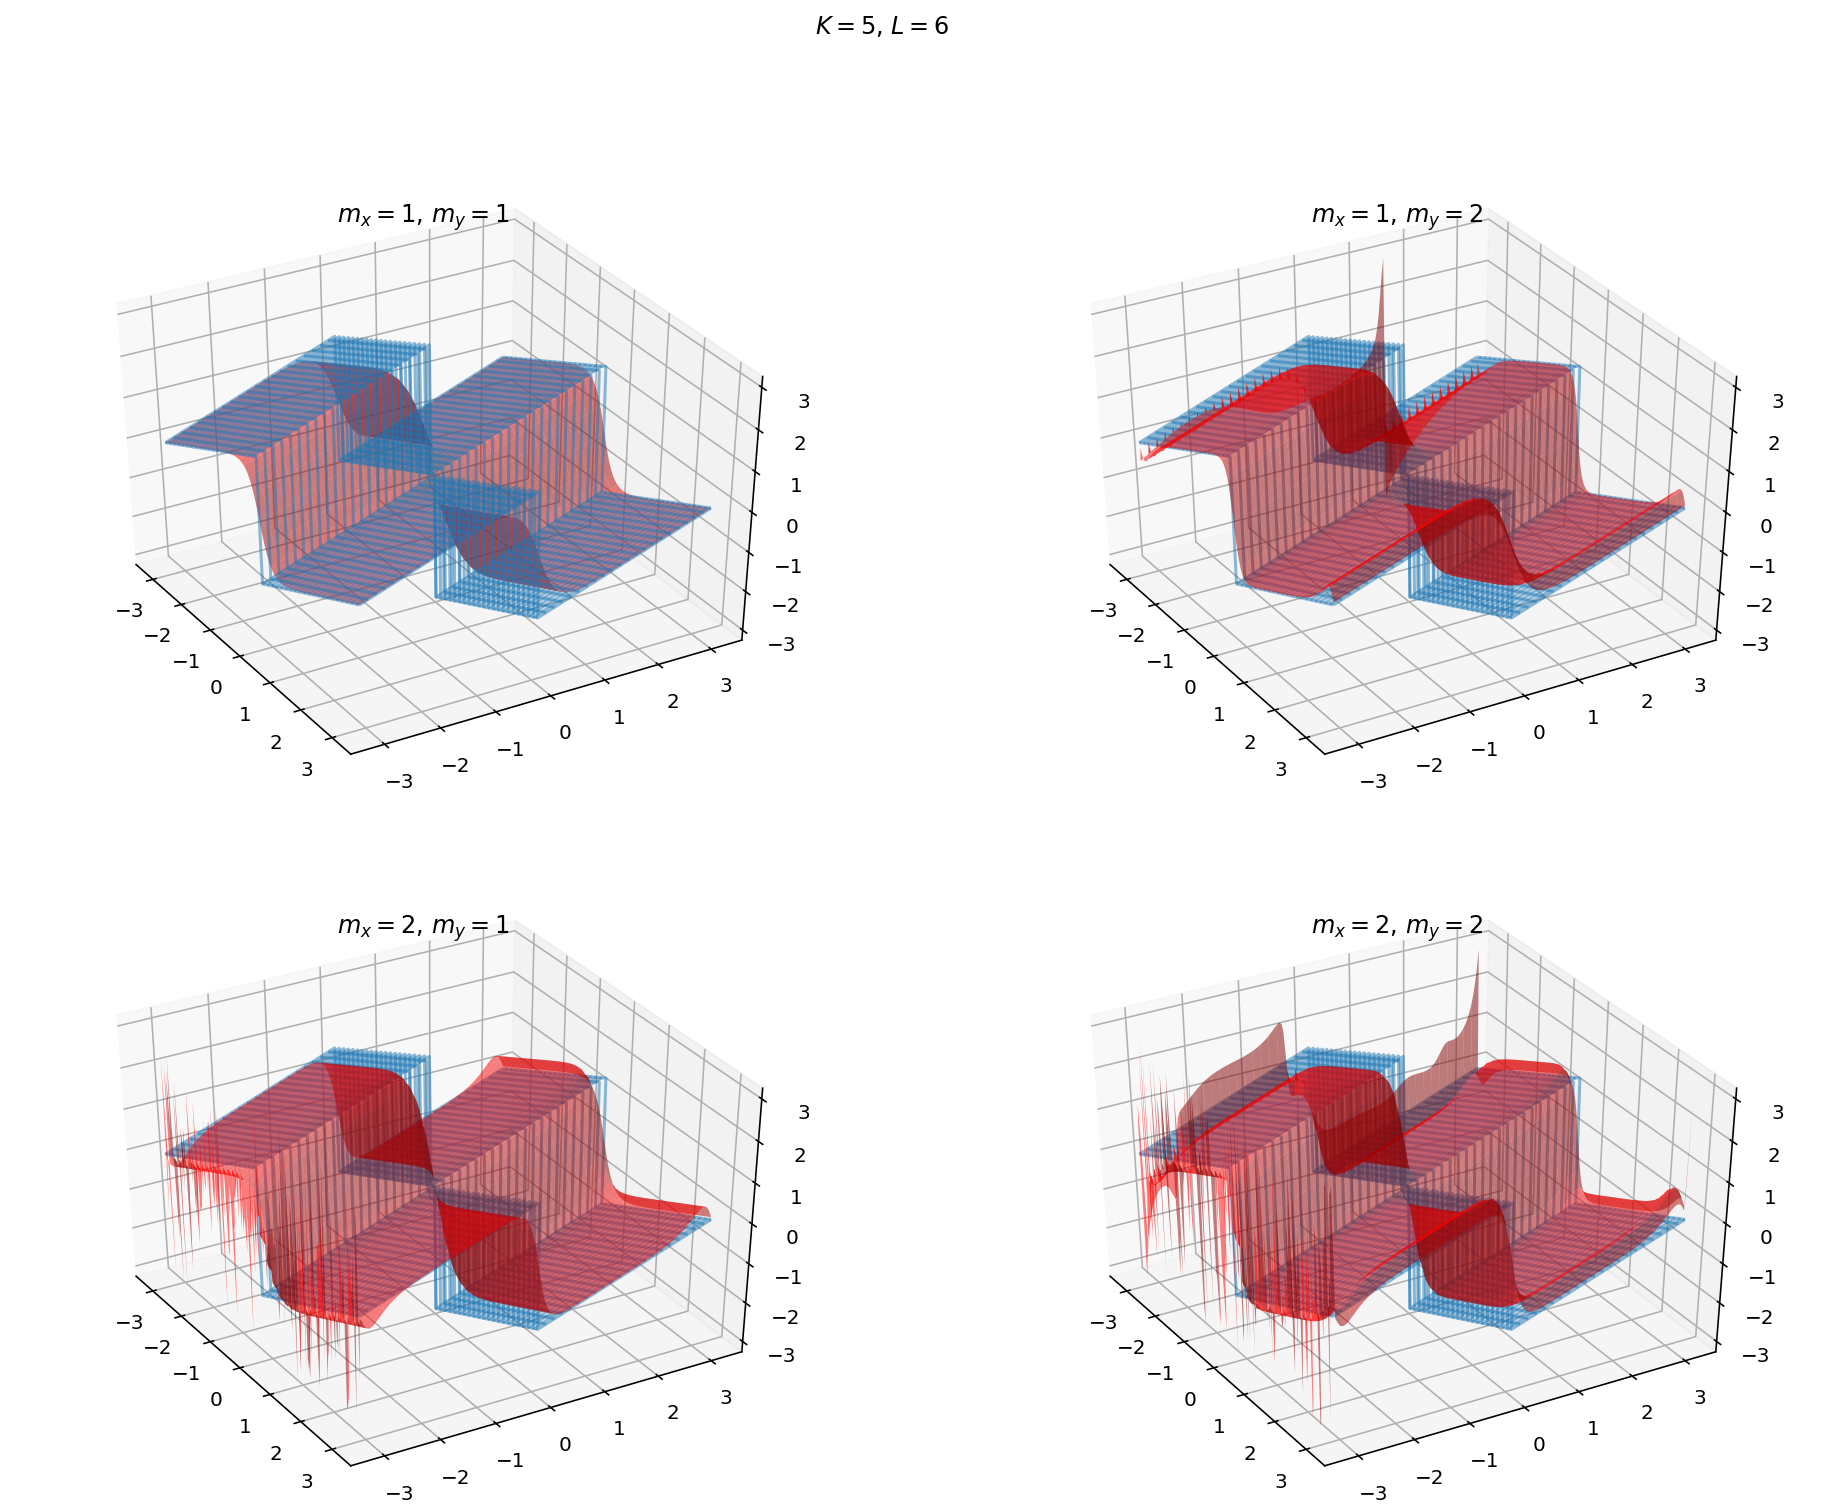

In [7]:
M = mera2d.selesnick(K=2, L=4)

fig = plt.figure(figsize=(16, 12))
fig.suptitle('$K = %d$, $L = %d$' % (K, L))
for m_x in [1, 2]:
    for m_y in [1, 2]:
        n, m, a, b = M.eigenmode_pair(m_x, m_y)
        k = np.arange(-np.pi, np.pi, .03)
        k_x, k_y = np.meshgrid(k, k)
        A = dtft2d(n, m, a, k)
        B = dtft2d(n, m, b, k)

        ax = fig.add_subplot(
            2,
            2,
            1 + (m_x - 1) * 2 + (m_y - 1),
            projection='3d',
            title='$m_x = %d$, $m_y = %d$' % (m_x, m_y))
        ax.plot_surface(k_x, k_y, np.angle(B / A), alpha=.5, color='r')
        ax.plot_wireframe(
            k_x,
            k_y,
            np.angle(
                -np.sign(k_x) * np.sign(k_y) * np.exp(1j * (k_x + k_y) / 2)),
            alpha=.5)
        # ax.plot_surface(k_x, k_y, np.abs(A))
        ax.elev, ax.azim, ax.dist = (38.332031207024556, -30.310472250627299,
                                     10)
plt.show()